# Übungsblatt 3 - Exercise 3b

In [2]:
#setup
import pandas as pd
from numpy import array
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_absolute_error

import tensorflow as tf

ModuleNotFoundError: No module named 'pandas'

In [1]:
#supress warning 
import warnings
warnings.filterwarnings('ignore')

#import data
data = pd.read_csv(". header=0, delimiter=';')
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
data = data.dropna(subset=['Global_active_power'])
#data["Global_active_power"] = data["Global_active_power"].astype(float)
data.shape

NameError: name 'pd' is not defined

Text(0.5, 1.0, 'Global_active_power')

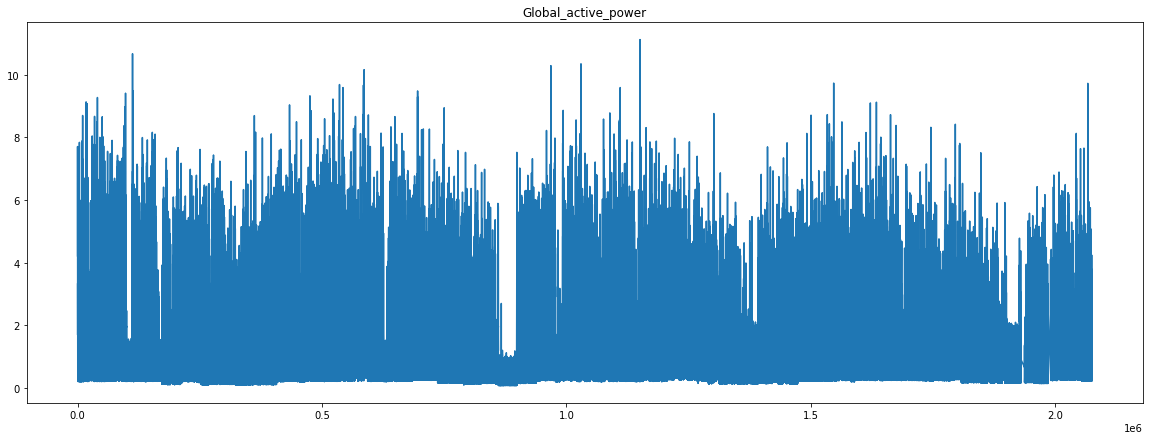

In [4]:
plt.figure(figsize=(20,7))
plt.plot(data.Global_active_power)
plt.title("Global_active_power")

In [5]:
#scale data
time_series = data.Global_active_power.values
time_series.shape
time_series = time_series.reshape(-1, 1)
scaler = MinMaxScaler()
time_series_scaled = scaler.fit_transform(time_series)
time_series

array([[4.216],
       [5.36 ],
       [5.374],
       ...,
       [0.938],
       [0.934],
       [0.932]])

In [6]:
def ts_to_training_data(ts, n_look_back=5):
    ts = array(ts)
    i = n_look_back + 1
    X, y, = [], []
    while i < len(ts): 
        X.append(ts[i-n_look_back:i].reshape(n_look_back, 1))
        y.append(ts[i])
        i +=1
    
    return array(X), array(y)

In [7]:
look_back = 4

X, y = ts_to_training_data(
    time_series_scaled, 
    n_look_back=look_back)

In [12]:
#shaping and splitting data set 
X.shape, y.shape
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3)
X_train, y_train = X_train_full[30:], y_train_full[30:]
X_valid, y_valid = X_train_full[:30], y_train_full[:30]
train_b = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
valid_b = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(64)
test_b = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

In [13]:
#method to train model (possibility to train the input data with different models by inserting the cell_class in the same setup)
def train_model(cell_class):
    model = Sequential()
    model.add(cell_class(4, input_shape=(look_back, 1)))
    model.add(Dense(1, activation="linear"))
    model.compile(
        loss=mean_squared_error,
        optimizer=Adam(),
        metrics=[
            mean_absolute_error
        ]
    )
    print(model.summary())
    train_history = model.fit(
        train_b,
        validation_data=valid_b,
        epochs=10,
        verbose=1
    )
    test_history = model.evaluate(test_b)
    return train_history, test_history, model

In [14]:
#method to plot the history of training and test prediction 
def plot_history(train, test):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

    ax[0].plot(train.history["loss"], label="train loss")
    ax[0].plot(train.history["val_loss"], label="val loss")
    ax[0].axhline(
        y=test[0],
        xmin=0,
        xmax=len(train.history["loss"]),
        color="green",
        ls=":",
        label="test loss"
    )
    ax[0].legend(loc=0)
    ax[0].set_title("Loss")

    ax[1].plot(train.history["mean_absolute_error"], label="train MAE")
    ax[1].plot(train.history["val_mean_absolute_error"], label="val MAE")
    ax[1].axhline(
        y=test[1],
        xmin=0,
        xmax=len(train.history["mean_absolute_error"]),
        color="green",
        ls=":",
        label="test acc"
    )
    ax[1].legend(loc=0)
    ax[1].set_title("Mean Absolute Error")

In [15]:
#Train Simmmple RNN, GRU & LSTM with Class Train Model

train_hist_srnn, test_hist_srnn, srnn_model = train_model(SimpleRNN)
#train_hist_gru, test_hist_gru, gru_model = train_model(GRU)
#train_hist_lstm, test_hist_lstm, lstm_model = train_model(LSTM)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
22414/22414 [==============================] - 38s 2ms/step - loss: 6.4726e-04 - mean_absolute_error: 0.0096 - val_loss: 1.2147e-05 - val_mean_absolute_error: 0.0029
Epoch 2/10
22414/22414 [==============================] - 38s 2ms/step - loss: 5.6562e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0566e-05 - val_mean_absolute_error: 0.0027
Epoch 3/10
22414/22414 [==============================] - 38s 2ms/step - loss: 5.6522e-04 - mean_absolute_error: 0.0088 - val_loss: 1.0520e-05 - val_mean_absolut

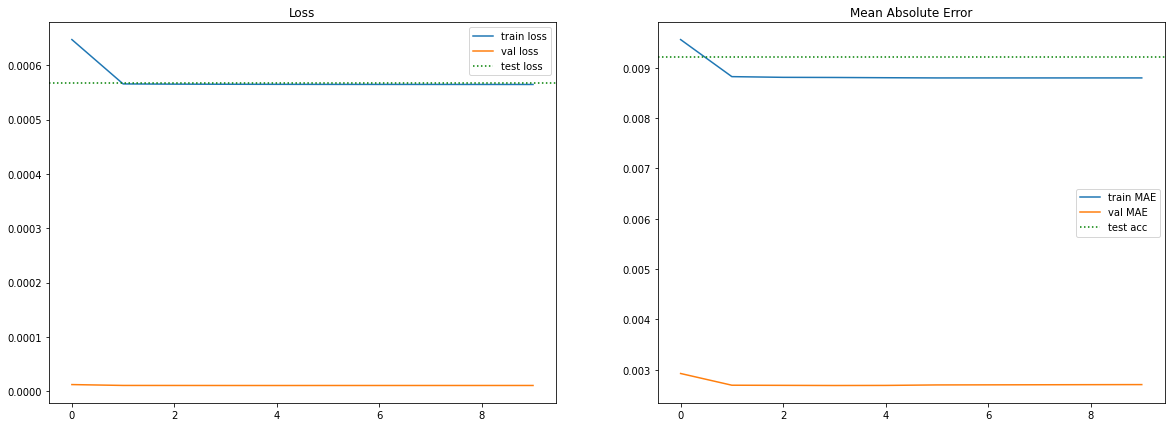

In [16]:
#Plot Train & Test History
plot_history(train_hist_srnn, test_hist_srnn)


In [17]:
def make_prediction(model):
    y_predicted = model.predict(X)
    plt.figure(figsize=(20,8))
    plt.plot(y_predicted, label="prdiction")
    plt.plot(y, label="actual")
    plt.legend(loc=0)

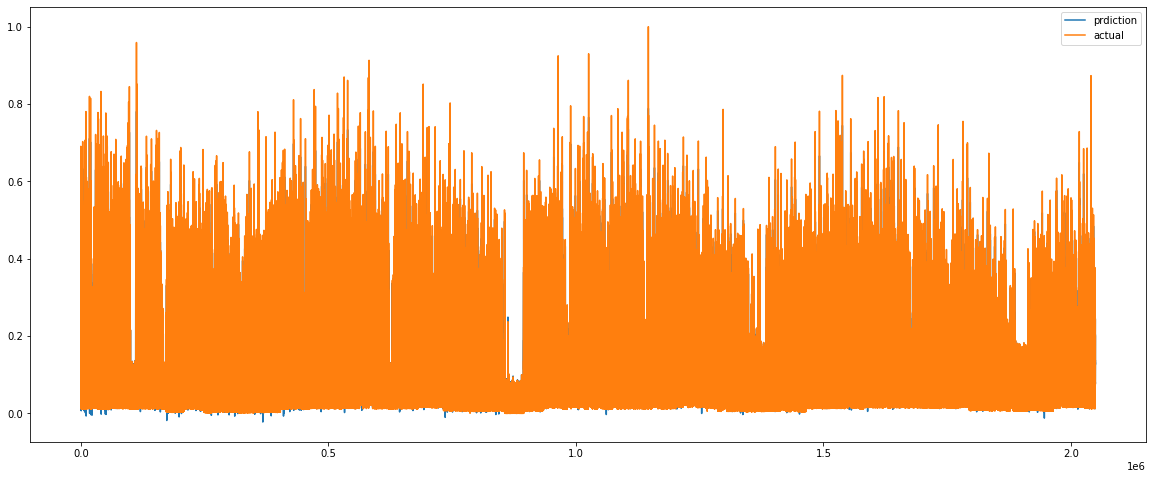

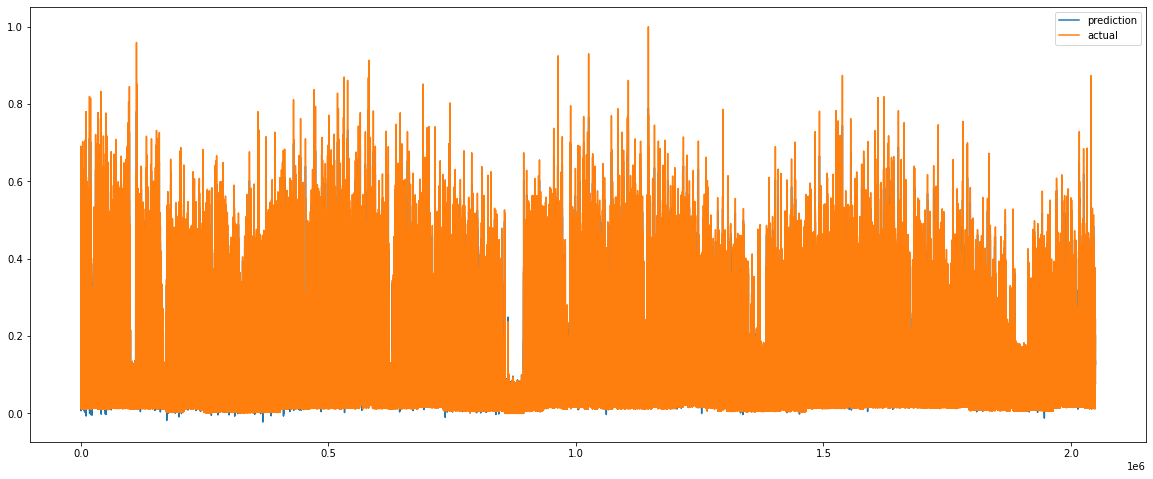

In [18]:
#predict and show results 
make_prediction(srnn_model)
y_predicted = srnn_model.predict(X)
plt.figure(figsize=(20,8))
plt.plot(y_predicted, label="prediction")
plt.plot(y, label="actual")
plt.legend(loc=0)